# Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.2-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Get genes that are likely ISGF3 binding

In [4]:
enc = encode.Encode('/data/home/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [5]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

In [6]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

In [7]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


### Get genes that are likely GAF binding

In [8]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])

In [9]:
potential_gaf_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [10]:
baseline_stat1_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF323QQU/@@download/ENCFF323QQU.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [11]:
gaf_genes =potential_gaf_genes #list(set(potential_gaf_genes) - set(baseline_stat1_genes))

### Read the REACTOME gene sets

In [12]:
# isgf3_genes = pd.read_csv('alpha_beta_reactome.txt', header=None)[0].tolist()
# gaf_genes = pd.read_csv('gamma_reactome.txt', header=None)[0].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [13]:
adata_processed = sc.read(data_path + 'HBEC_type_I_processed.h5ad')

In [14]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')
adata.obs.donor.value_counts()

d2513    34957
d2614    34295
Name: donor, dtype: int64

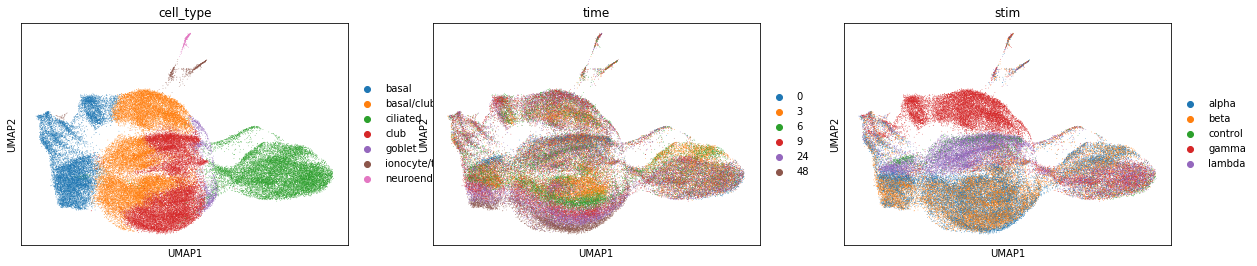

In [15]:
sc.pl.umap(adata_processed, color=['cell_type', 'time', 'stim'])

In [16]:
# adata = adata[
#     adata.obs.cell_type.isin(['club', 'basal/club']) & \
#     adata.obs.stim.isin(['control','beta'])].copy()

In [17]:
adata.shape

(69252, 36601)

### Define lists

In [18]:
adata.obs.time.drop_duplicates()

AAACCCAAGGAAGTAG-1     9
AAACCCAAGGGACTGT-1    24
AAACCCACAATCTGCA-1     3
AAACCCACAGAACTAA-1    48
AAACCCACAGTATTCG-1     6
AAACGCTAGTGAATAC-1     0
Name: time, dtype: category
Categories (6, object): [0, 3, 6, 9, 24, 48]

In [19]:
cts = [['ciliated'], ['basal/club', 'club'], ['basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

### Run memento

In [21]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            adata_stim = adata[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp])
                ].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'], inplace=True, q=0.25*0.2)
            memento.compute_size_factors(adata_stim, trim_percent=0.05)
            memento.compute_1d_moments(adata_stim, inplace=True, filter_mean_thresh=0.07, min_perc_group=.9)

            memento.ht_1d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)
            
            del adata_stim.uns['memento']['mv_regressor']
            
            adata_stim.write('/data_volume/ifn_hbec/binary_test/{}_{}_{}.h5ad'.format(
                '-'.join(ct), stim, tp))

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.2-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    8.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   18.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   29.9s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   45.0s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.4min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.9min
[Parallel(n_jobs=13)]: Done 5389 out of 5389 | elapsed:  3.2min finished
... storing 'memento_group' as categorical
[Parallel(n_jobs=13)]: Using bac

OSError: Unable to create file (unable to open file: name = '/data_volume/ifn_hbec/binary_test/basal/club-club_alpha_3.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### Perform 1D test between control and 3 hours for gamma


In [19]:
tp_list = ['3']

In [20]:
beta_dicts = {}
for tp in tp_list:
    
    adata_stim = adata[
        adata.obs.cell_type.isin(['basal/club', 'club', 'basal', 'goblet']) & \
        adata.obs.stim.isin(['control','beta']) & \
        adata.obs.time.isin(['0',tp])
        ].copy()
    time_converter={0:0, int(tp):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    
    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'], inplace=True, q=0.25*0.2)
    memento.compute_size_factors(adata_stim, trim_percent=0.05)
    memento.compute_1d_moments(adata_stim, inplace=True, filter_mean_thresh=0.07, min_perc_group=.9)

    memento.ht_1d_moments(
        adata_stim, 
        formula_like='1 + time_step',
        cov_column='time_step', 
        num_boot=10000, 
        verbose=1,
        num_cpus=13)
    
    beta_dicts[tp] = adata_stim.copy()


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.2-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    9.6s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   19.8s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   32.5s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   48.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  2.1min
[Parallel(n_jobs=13)]

In [21]:
gamma_dicts = {}
for tp in tp_list:
    
    adata_stim = adata[
        adata.obs.cell_type.isin(['basal/club', 'club', 'basal', 'goblet']) & \
        adata.obs.stim.isin(['control','gamma']) & \
        adata.obs.time.isin(['0',tp])
        ].copy()
    time_converter={0:0, int(tp):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    
    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'], inplace=True, q=0.25*0.2)
    memento.compute_size_factors(adata_stim, trim_percent=0.05)
    memento.compute_1d_moments(adata_stim, inplace=True, filter_mean_thresh=0.07, min_perc_group=.9)

    memento.ht_1d_moments(
        adata_stim, 
        formula_like='1 + time_step',
        cov_column='time_step', 
        num_boot=10000, 
        verbose=1,
        num_cpus=13)
    
    gamma_dicts[tp] = adata_stim.copy()


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.2-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    6.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   16.4s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   28.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   44.8s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]

In [22]:
alpha_dicts = {}
for tp in tp_list:
    
    adata_stim = adata[
        adata.obs.cell_type.isin(['basal/club', 'club', 'basal', 'goblet']) & \
        adata.obs.stim.isin(['control','alpha']) & \
        adata.obs.time.isin(['0',tp])
        ].copy()
    time_converter={0:0, int(tp):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    
    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'], inplace=True, q=0.25*0.2)
    memento.compute_size_factors(adata_stim, trim_percent=0.05)
    memento.compute_1d_moments(adata_stim, inplace=True, filter_mean_thresh=0.07, min_perc_group=.9)

    memento.ht_1d_moments(
        adata_stim, 
        formula_like='1 + time_step',
        cov_column='time_step', 
        num_boot=10000, 
        verbose=1,
        num_cpus=13)
    
    alpha_dicts[tp] = adata_stim.copy()


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.2-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    6.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   15.9s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   28.2s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   44.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]

In [232]:
def classify_gene(x):
    
    isgf3 = x in isgf3_genes
    gaf = x in gaf_genes
    
    if gaf & isgf3:
        return ['isgf3', 'gaf']
    elif gaf:
        return ['gaf']
    elif isgf3:
        return ['isgf3']
    else:
        return ['rest']

beta_dfs = []
for tp in tp_list:
    
    result_1d_stim = memento.get_1d_ht_result(beta_dicts[tp])
    result_1d_stim['isgf3'] = result_1d_stim.gene.apply(lambda x: x in isgf3_genes)
    result_1d_stim['gaf'] = result_1d_stim.gene.apply(lambda x: x in gaf_genes)
    result_1d_stim['cat'] = result_1d_stim.gene.apply(classify_gene)
    result_1d_stim['de_fdr'] = memento.util._fdrcorrect(result_1d_stim['de_pval'])

    upreg_1d_stim = result_1d_stim.query('de_fdr < 0.1 & de_coef > 0 & ~gene.str.contains("MT-").values').copy()
    upreg_1d_stim['tp'] = int(tp)
    beta_dfs.append(upreg_1d_stim)
beta_df = pd.concat(beta_dfs)
beta_df = beta_df.explode('cat').sort_values('cat', ascending=False)

gamma_dfs = []
for tp in tp_list:
    
    result_1d_stim = memento.get_1d_ht_result(gamma_dicts[tp])
    result_1d_stim['isgf3'] = result_1d_stim.gene.apply(lambda x: x in isgf3_genes)
    result_1d_stim['gaf'] = result_1d_stim.gene.apply(lambda x: x in gaf_genes)
    result_1d_stim['cat'] = result_1d_stim.gene.apply(classify_gene)
    result_1d_stim['de_fdr'] = memento.util._fdrcorrect(result_1d_stim['de_pval'])

    upreg_1d_stim = result_1d_stim.query('de_fdr < 0.1 & de_coef > 0 & ~gene.str.contains("MT-").values').copy()
    upreg_1d_stim['tp'] = int(tp)
    gamma_dfs.append(upreg_1d_stim)
gamma_df = pd.concat(gamma_dfs)
gamma_df = gamma_df.explode('cat').sort_values('cat', ascending=False)

alpha_dfs = []
for tp in tp_list:
    
    result_1d_stim = memento.get_1d_ht_result(alpha_dicts[tp])
    result_1d_stim['isgf3'] = result_1d_stim.gene.apply(lambda x: x in isgf3_genes)
    result_1d_stim['gaf'] = result_1d_stim.gene.apply(lambda x: x in gaf_genes)
    result_1d_stim['cat'] = result_1d_stim.gene.apply(classify_gene)
    result_1d_stim['de_fdr'] = memento.util._fdrcorrect(result_1d_stim['de_pval'])

    upreg_1d_stim = result_1d_stim.query('de_fdr < 0.1 & de_coef > 0 & ~gene.str.contains("MT-").values').copy()
    upreg_1d_stim['tp'] = int(tp)
    alpha_dfs.append(upreg_1d_stim)
alpha_df = pd.concat(alpha_dfs)
alpha_df= alpha_df.explode('cat').sort_values('cat', ascending=False)


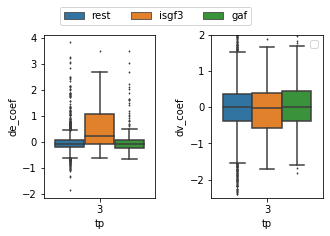

In [223]:
# plt.figure(figsize=(3, 5))
plt.figure(figsize=(5, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
sns.boxplot(x='tp', y='de_coef', hue='cat', data=gamma_df, fliersize=1)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(1, 1.2))
plt.subplot(1, 2, 2)
sns.boxplot(x='tp', y='dv_coef', hue='cat', data=gamma_df, fliersize=1)
plt.legend([])
plt.ylim(-2.5, 2);

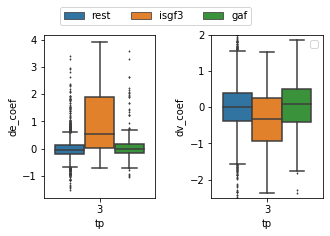

In [224]:
# plt.figure(figsize=(3, 5))
plt.figure(figsize=(5, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
sns.boxplot(x='tp', y='de_coef', hue='cat', data=beta_df, fliersize=1)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(1, 1.2))
plt.subplot(1, 2, 2)
sns.boxplot(x='tp', y='dv_coef', hue='cat', data=beta_df, fliersize=1)
plt.legend([])
plt.ylim(-2.5, 2);

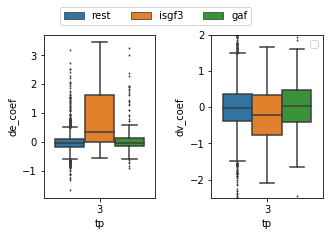

In [225]:
# plt.figure(figsize=(3, 5))
plt.figure(figsize=(5, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
sns.boxplot(x='tp', y='de_coef', hue='cat', data=alpha_df, fliersize=1)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(1, 1.2))
plt.subplot(1, 2, 2)
sns.boxplot(x='tp', y='dv_coef', hue='cat', data=alpha_df, fliersize=1)
plt.legend([])
plt.ylim(-2.5, 2);

In [234]:
gamma_df['stim'] = 'gamma'
beta_df['stim'] = 'beta'
alpha_df['stim'] = 'alpha'

(-2.5, 2)

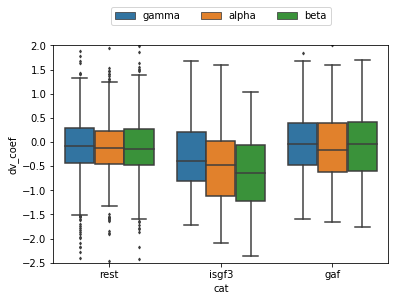

In [235]:
sns.boxplot(x='cat', y='dv_coef', hue='stim', data=pd.concat([gamma_df, alpha_df, beta_df]), fliersize=2)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5,1.2))
plt.ylim(-2.5, 2)

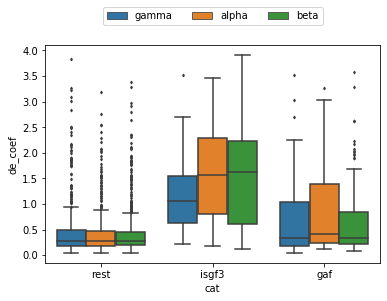

In [236]:
sns.boxplot(x='cat', y='de_coef', hue='stim', data=pd.concat([gamma_df, alpha_df, beta_df]), fliersize=2)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5,1.2))
# plt.ylim(-2.5, 2)

In [231]:
stats.mannwhitneyu(gamma_df.query('cat == "gaf"').dv_coef.values, gamma_df.query('cat == "rest"').dv_coef.values)

MannwhitneyuResult(statistic=626244.0, pvalue=0.14624967233149005)

### Predicting the network topology

In [125]:
df = beta_df.query('de_coef > ').copy()
df['prod'] = df['de_coef'] * df['dv_coef'].clip()

In [126]:
df.groupby('isgf3').de_coef.mean()

isgf3
False    2.085986
True     2.411574
Name: de_coef, dtype: float64

Average precision-recall score: 0.61
ROC AUC score: 0.87


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


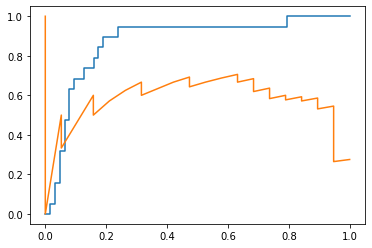

In [124]:
from sklearn import datasets, svm, linear_model
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = df[['de_coef', 'prod']].values
y = df['isgf3'].values

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.3,
                                                    random_state=0)

# Create a simple classifier
classifier = linear_model.LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

from sklearn.metrics import average_precision_score, roc_auc_score
average_precision = average_precision_score(y_test, y_score)
roc_score = roc_auc_score(y_test, y_score)


print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
print('ROC AUC score: {0:0.2f}'.format(
      roc_score))

from sklearn.metrics import precision_recall_curve, roc_curve

fpr, tpr, t_roc = roc_curve(y_test, y_score)
p, r, t = precision_recall_curve(y_test, y_score)

plt.plot(fpr, tpr)
plt.plot(r, p)

In [80]:
result_1d_stim = memento.get_1d_ht_result(adata_beta_stim)
result_1d_stim['isgf3'] = result_1d_stim.gene.apply(lambda x: x in isgf3_genes)
result_1d_stim['gaf'] = result_1d_stim.gene.apply(lambda x: x in gaf_genes)
result_1d_stim['de_fdr'] = memento.util._fdrcorrect(result_1d_stim['de_pval'])

upreg_1d_stim = result_1d_stim.query('de_fdr < 0.1 & de_coef > 0 & ~gene.str.contains("MT-").values')
# de_genes = result_1d_overall.query('de_fdr < 0.05 & de_coef > 0 & ~gene.str.contains("MT-").values').gene.tolist()

In [81]:
isgf3_coef_beta_stim = upreg_1d_beta_stim.query('isgf3').dv_coef
gaf_coef_beta_stim = upreg_1d_beta_stim.query('gaf').dv_coef
rest_beta_stim = upreg_1d_beta_stim.query('~gaf & ~isgf3').dv_coef

In [82]:
upreg_1d_beta_stim.query('gaf').shape

(107, 8)

In [85]:
print(upreg_1d_beta_stim.query('isgf3').de_coef.mean())
print(upreg_1d_beta_stim.query('gaf').de_coef.mean())
print(upreg_1d_beta_stim.query('~gaf & ~isgf3').de_coef.mean())

1.5351404817542058
0.6840223288250579
0.41601249991989186


In [86]:
print(upreg_1d_beta_stim.query('isgf3').dv_coef.mean())
print(upreg_1d_beta_stim.query('gaf').dv_coef.mean())
print(upreg_1d_beta_stim.query('~gaf & ~isgf3').dv_coef.mean())

-0.7008869795698967
-0.15414888970512092
-0.09581477698362235


In [38]:
upreg_1d_beta_stim.query('gaf').de_coef.mean()

0.7385836054943499

In [64]:
result_1d_overall.query('gene == "HES4"')

,gene,de_coef,de_pval,dv_coef,dv_pval,de_fdr
0,HES4,0.749431,6.860194e-07,0.09733,0.213,0.000002


### Plot the progression for these DE genes

In [278]:
adata_processed.obs.cell_type.drop_duplicates()

AAACCCAAGGAAGTAG-1         ciliated
AAACCCAAGGGACTGT-1             club
AAACCCACAATCTGCA-1            basal
AAACCCACAGAACTAA-1       basal/club
AAACGCTAGCCGAACA-1        neuroendo
AAACGCTGTGCCGTTG-1    ionocyte/tuft
AAAGTCCCATGTGCTA-1           goblet
Name: cell_type, dtype: category
Categories (7, object): ['basal', 'basal/club', 'ciliated', 'club', 'goblet', 'ionocyte/tuft', 'neuroendo']

In [283]:
def plot_progression(ct, gene, stim):
    
    adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')
    
    adata = adata[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control',stim])].copy()
    time_converter={0:0, 3:1, 6:2, 9:3, 24:4, 48:5}
    adata.obs['time_step'] = adata.obs['time'].astype(int).apply(lambda x: time_converter[x])
    memento.create_groups(adata, label_columns=['time_step'], inplace=True, q=0.25*0.2)
    memento.compute_size_factors(adata, trim_percent=0.05)
    memento.compute_1d_moments(adata, inplace=True, filter_mean_thresh=0.2, min_perc_group=.9, filter_genes=False)
    moments_mean, moments_var, _ = memento.get_1d_moments(adata)
    plot_time_expr(gene, moments_mean, moments_var, ct, stim)
    
def plot_time_expr(gene, moments_mean, moments_var, ct, stim):
    
    plt.figure(figsize=(10,3));
    plt.subplots_adjust(wspace=0.3)
    plt.subplot(1, 2, 1);
    plt.title('{} mean'.format(gene))
    plt.scatter(np.arange(6), moments_mean[moments_mean.columns.sort_values()].query('gene == "{}"'.format(gene)).iloc[0, 1:].values)
    plt.subplot(1, 2, 2);
    plt.title('{} variability {} {}'.format(gene, ct, stim))
    plt.scatter(np.arange(6), moments_var[moments_var.columns.sort_values()].query('gene == "{}"'.format(gene)).iloc[0, 1:].values)
    plt.xlabel('tp'); plt.ylabel('variability')

ciliated
club
basal
basal/club
neuroendo
ionocyte/tuft
goblet


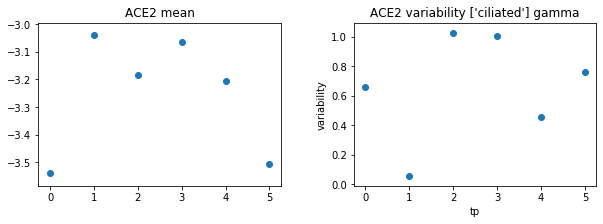

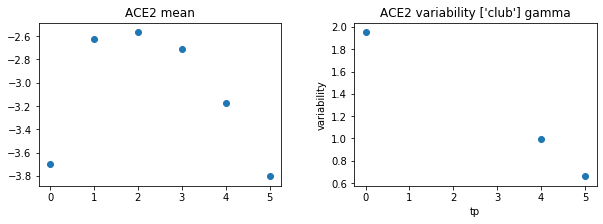

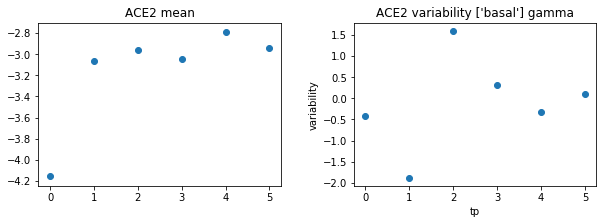

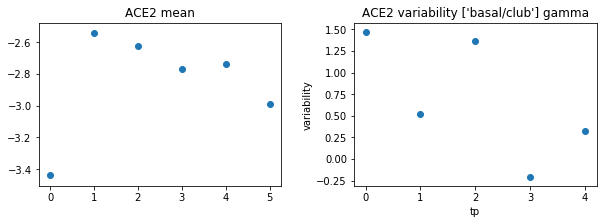

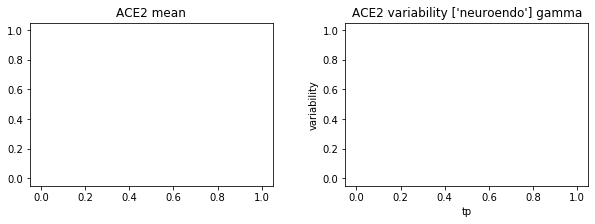

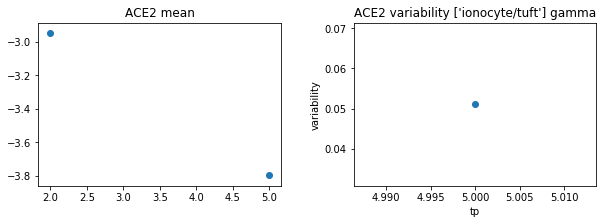

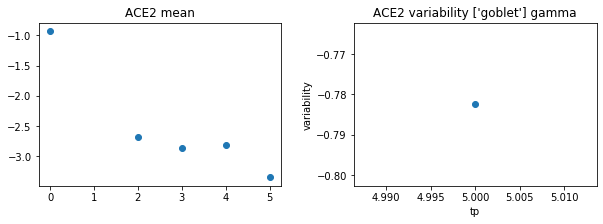

In [284]:
for ct in adata_processed.obs.cell_type.drop_duplicates():
    print(ct)
    plot_progression([ct], 'ACE2', 'gamma')

In [255]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')

In [256]:
adata.obs.cell_type.value_counts()

basal/club       22029
club             18276
ciliated         14631
basal            12200
goblet            1353
ionocyte/tuft      544
neuroendo          219
Name: cell_type, dtype: int64

In [257]:
adata = adata[
#     adata.obs.cell_type.isin(['basal/club', 'club', 'basal', 'goblet']) & \
    adata.obs.stim.isin(['control','gamma'])].copy()

In [258]:
time_converter={0:0, 3:1, 6:2, 9:3, 24:4, 48:5}
adata.obs['time_step'] = adata.obs['time'].astype(int).apply(lambda x: time_converter[x])

In [259]:
memento.create_groups(adata, label_columns=['time_step'], inplace=True, q=0.25*0.2)
memento.compute_size_factors(adata, trim_percent=0.05)
memento.compute_1d_moments(adata, inplace=True, filter_mean_thresh=0.2, min_perc_group=.9, filter_genes=False)

In [260]:
moments_mean, moments_var, _ = memento.get_1d_moments(adata)

In [261]:
def plot_time_expr(gene):
    
    plt.figure(figsize=(10,3));
    plt.subplots_adjust(wspace=0.3)
    plt.subplot(1, 2, 1);
    plt.title('{} mean'.format(gene))
    plt.scatter(np.arange(6), moments_mean[moments_mean.columns.sort_values()].query('gene == "{}"'.format(gene)).iloc[0, 1:].values)
    plt.subplot(1, 2, 2);
    plt.title('{} variability'.format(gene))
    plt.scatter(np.arange(6), moments_var[moments_var.columns.sort_values()].query('gene == "{}"'.format(gene)).iloc[0, 1:].values)
    plt.xlabel('tp'); plt.ylabel('variability')

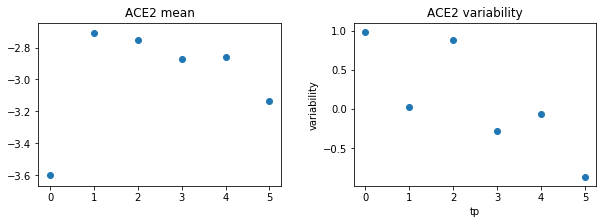

In [271]:
plot_time_expr('ACE2');

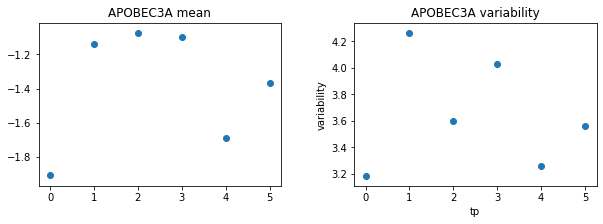

In [270]:
plot_time_expr('APOBEC3A');

<Figure size 432x216 with 0 Axes>

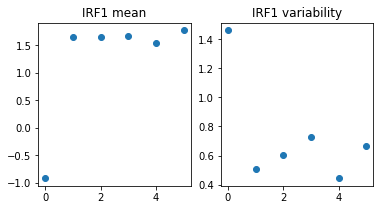

In [56]:
plt.figure(figsize=(6, 3));
plot_time_expr('IRF1');

In [58]:
moments_mean[moments_mean.columns.sort_values()].query('gene == "ISG15"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
1,ISG15,0.663902,3.565735,3.838548,3.959382,4.057398,3.786915


In [59]:
moments_var[moments_var.columns.sort_values()].query('gene == "ISG15"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
1,ISG15,2.423768,-0.288747,-0.020755,0.040945,-0.055663,0.185579


In [41]:
moments_mean[moments_mean.columns.sort_values()].query('gene == "SAT1"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
2313,SAT1,2.738188,3.175648,3.054841,3.314051,3.373495,3.202804


In [42]:
moments_var[moments_var.columns.sort_values()].query('gene == "SAT1"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
2313,SAT1,0.966216,-0.164159,0.026237,0.397797,0.051375,0.285033


In [67]:
adata.shape

(7406, 2576)

In [68]:
memento.ht_1d_moments(
    adata, 
    formula_like='1 + time_step',
    cov_column='time_step', 
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    8.4s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   15.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   25.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   38.5s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   55.0s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 2576 out of 2576 | elapsed:  1.4min finished


In [69]:
moments_1d = memento.get_1d_moments(adata)

In [70]:
moments_1d[1][moments_1d[1].columns.sort_values()].query('gene == "TXN"')

,gene,sg^0,sg^1
1197,TXN,-0.442353,0.22366


In [71]:
result_1d = memento.get_1d_ht_result(adata)


In [74]:
moments_1d[1].query('gene == "SAT1"')

,gene,sg^1,sg^0
2502,SAT1,-0.242884,0.523133


In [76]:
result_1d.query('gene == "SAT1"')

,gene,de_coef,de_pval,dv_coef,dv_pval
2502,SAT1,0.293283,2.999310e-07,-0.766018,1.016518e-12
